 # Introduction to Chinook with Graphene

In the following exercise, we'll get a feeling for building and characterizing tight-binding models in chinook, in addition to some calculation of the associated ARPES intensity. I'll use graphene for this exercise.

I'll start by importing the requisite python libraries -- including the necessary chinook files. Numpy is the standard python numerics package. 

In [1]:
import numpy as np

import chinook.build_lib as build_lib
import chinook.ARPES_lib as arpes_lib
import chinook.operator_library as op_lib
import chinook.orbital_plotting as oplot

Personally, I like to keep my model setup and my calculation execution in separate .py scripts. For the sake of code readability this helps a lot. For this Jupyter notebook though, I'm going to do things sort of linearly. It gets a bit cluttered, but will help with the flow. Have a look at the .py files saved on the same page as this notebook for the same exercises written in native python scripts.

To define a tight-binding model, I'll need four things: a lattice, an orbital basis, a Hamiltonian, and a momentum path of interest. We start with the lattice.

In [2]:
alatt = 2.46
interlayer = 100.0
    
avec = np.array([[-alatt/2,alatt*np.sqrt(3/4.),0.0],
                [alatt/2,alatt*np.sqrt(3/4.),0.0],
                [0.0,0.0,interlayer]]) 

Even though we are doing a 2D lattice, it's embedded in 3D space we live in. I've then defined an 'interlayer' distance, but this is fictitiously large so there will not be any 'interlayer' coupling. Next, we define our orbital basis:

In [3]:
spin_args = {'bool':False}
    
basis_positions = np.array([[0.0,0.0,0.0],
                            [0.0,alatt/np.sqrt(3.0),0.0]])

basis_args = {'atoms':[0,0],
                  'Z':{0:6},
                  'orbs':[["20","21x","21y","21z"],["20","21x","21y","21z"]],
                  'pos':basis_positions,
                  'spin':spin_args}

I'm going to ignore the spin-degree of freedom so I'm turning off the spin-switch. In other systems, these 'spin_args' allow for incorporation of spin-orbit coupling and magnetic ordering. The graphene lattice has two basis atoms per unit cell, and for now I'll include the full Carbon 2sp orbital space. This is a good point to clarify that most objects we define in chinook are generated using the 'dictionary' structure I've used here, where we use key-value pairs to define attributes in a user-readable fashion. 

After the basis, I'll define my Hamiltonian. Following the introduction to Slater-Koster tight-binding, I define the relevant hoppings in the SK dictionary. The keys specify the atoms and orbitals associated with the hopping value. For example, '002211P' corresponds to the $V_{pp\pi}$ hopping between the 0$^{th}$ and 0$^{th}$ atom in our basis, coupling specifically the 2p (n=2, l=1) states.

In [4]:
SK = {"020":-8.81,"021":-0.44,       #onsite energies
          "002200S":-5.279,               #nearest-neighbour Vssσ
          "002201S":5.618,                #nearest-neighbour Vspσ
          "002211S":6.05,"002211P":-3.07} #nearest-neighbour Vppσ,Vppπ
    
        
hamiltonian_args = {'type':'SK',
                    'V':SK,
                    'avec':avec,
                    'cutoff':alatt*0.7,
                    'spin':spin_args}

Before building our model, the last thing I'll do is specify a k-path along which I want to find the band-structure.

In [5]:
G = np.array([0,0,0])
K = np.array([1./3,2./3,0])
M = np.array([0,0.5,0.0])
    
momentum_args= {'type':'F',
                'avec':avec,
                'grain':200,
                'pts':[G,K,M,G],
                'labels':['$\\Gamma$','K','M','$\\Gamma$']}

Finally then, I'll use the chinook.build_library to actually construct a tight-binding model for our use here

In [6]:
basis = build_lib.gen_basis(basis_args)
kpath = build_lib.gen_K(momentum_args)
TB = build_lib.gen_TB(basis,hamiltonian_args,kpath)

With this model so defined, I can now compute the eigenvalues along my k-path of interest:

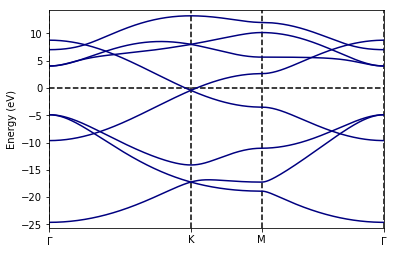

In [7]:
TB.solve_H()
TB.plotting()

We see very nicely then the linear Dirac dispersion for which graphene is so famous, in addition the the sigma-bonding states at higher energies below $E_F$, composed of sp$_2$ hybrids, from which its mechanical strength is derived. Note also that I've chosen to n-dope my graphene, shifting the Dirac point below the chemical potential. Such a shift is routinely observed in graphene which is not free-standing, as typically used in ARPES experiments.

To understand the orbital composition more explicitly, I can compute the projection of the tight-binding eigenvectors onto the orbitals of my basis using the chinook.operator_library. Before doing so, I'll use a built-in method for the TB model object we've created to determine clearly, my orbital basis:

In [8]:
TB.print_basis_summary()

 Index | Atom | Label | Spin |     Position     
    0  |   0  |20     |   0.5| 0.000,0.000,0.000
    1  |   0  |21x    |   0.5| 0.000,0.000,0.000
    2  |   0  |21y    |   0.5| 0.000,0.000,0.000
    3  |   0  |21z    |   0.5| 0.000,0.000,0.000
    4  |   0  |20     |   0.5| 0.000,1.420,0.000
    5  |   0  |21x    |   0.5| 0.000,1.420,0.000
    6  |   0  |21y    |   0.5| 0.000,1.420,0.000
    7  |   0  |21z    |   0.5| 0.000,1.420,0.000


Clearly, orbitals [0,4] are 2s, [1,5] are 2p$_x$, [2,6] are 2p$_y$ and [3,7] are 2p$_z$. I'll use the op_lib.fatbs function to plot 'fat' bands for these basis combinations:

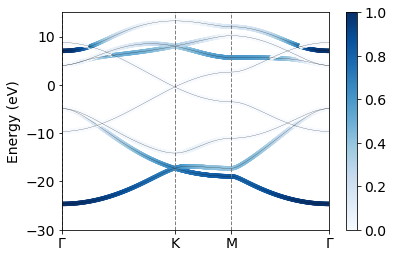

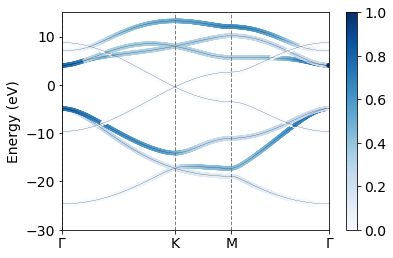

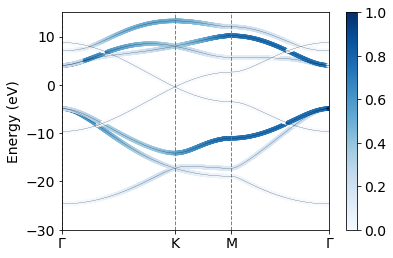

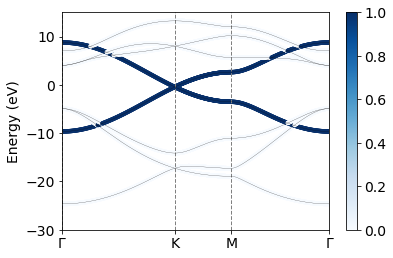

In [9]:
C2s = op_lib.fatbs([0,4],TB,Elims=(-30,15))
C2x = op_lib.fatbs([1,5],TB,Elims=(-30,15))
C2y = op_lib.fatbs([2,6],TB,Elims=(-30,15))
C2z = op_lib.fatbs([3,7],TB,Elims=(-30,15))

From these results, it's immediatedly obvious that if I am only concerned with the low-energy physics near the chemical potential (within $\pm$ 3 eV), then it is perfectly reasonable to adopt a model with only p$_z$ orbitals. I can actually redefine my model accordingly.

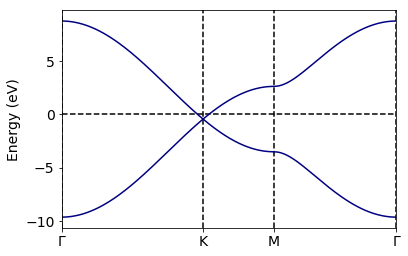

In [10]:
basis_args = {'atoms':[0,0],
              'Z':{0:6},
              'orbs':[["21z"],["21z"]],
              'pos':basis_positions,
              'spin':spin_args}

basis = build_lib.gen_basis(basis_args)
TB_pz = build_lib.gen_TB(basis,hamiltonian_args,kpath)

TB_pz.solve_H()
TB_pz.plotting()

The only difference in the above was that I redined the "orbs" argument for the basis definition, cutting out the "20", "21x", "21y" states. There is some redundancy left in this model, specifically I have defined additional hopping elements and onsite energies (for the 2s) which will not be used. 

Let's shift our attention to ARPES. In ARPES experiments, one usually only sees one side of the Dirac cone. This is due to interference between the  the two sublattice sites. To understand this, we can plot directly the tight-binding eigenvectors near the K-point. Since we defined our k-path with 200 points between each high-symmetry point, I'll plot the eigenvectors at the 190$^{th}$ k-point.

/Users/ryanday/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


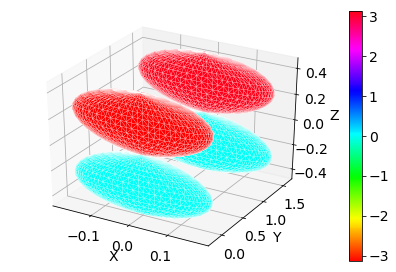

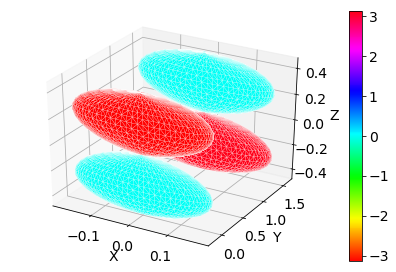

In [11]:
eigenvector1 = TB_pz.Evec[190,:,0]
eigenvector2 = TB_pz.Evec[190,:,1]

wfunction1 = oplot.wavefunction(basis=TB_pz.basis,vector=eigenvector1)
wfunction2 = oplot.wavefunction(basis=TB_pz.basis,vector=eigenvector2)

wplot1 = wfunction1.triangulate_wavefunction(20)
wplot2 = wfunction2.triangulate_wavefunction(20)

 We see that the lower-energy state is the symmetric combination of sites $A$ and $B$, whereas the higher energy state is the antisymmetric combination. So we can anticipate that the symmetric state will produce constructive interference, whereas the antisymmetric will destructively interfere. Ok, let's continue with this model to calculate the ARPES spectra. 

In [12]:
Kpt = np.array([1.702,0.0,0.0])
klimits = 0.1
Elimits = [-1.25,0.25]
Npoints = 100

arpes_args={'cube':{'X':[Kpt[0]-klimits,Kpt[0]+klimits,Npoints],
                    'Y':[Kpt[1]-klimits,Kpt[1]+klimits,Npoints],
                    'kz':Kpt[2],
                    'E':[Elimits[0],Elimits[1],1000]},
            
                'SE':['poly',0.01,0,0.1], #Self-energy arguments (lineshape)
                'hv': 21.2,               # Photon energy (eV)
                'pol':np.array([-1,0,1]), #light-polarization
                'resolution':{'E':0.02,'k':0.005}, #energy, momentum resolution
                'T':4.2}                  #Temperature (for Fermi distribution)

Initiate diagonalization: 
Diagonalization Complete.
Begin computing matrix elements: 
||||||||||||||||||||||||||||||100%
Done matrix elements


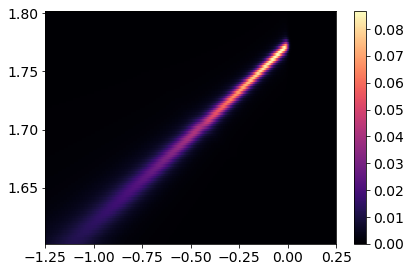

In [13]:
experiment = arpes_lib.experiment(TB_pz,arpes_args)
experiment.datacube()
Imap,Imap_resolution,axes = experiment.spectral(slice_select=('y',0))

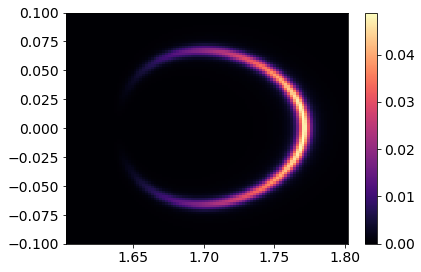

In [14]:
Imap,Imap_resolution,axes = experiment.spectral(slice_select=('E',0))

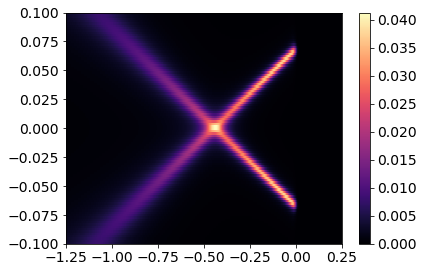

In [15]:
Imap,Imap_resolution,axes = experiment.spectral(slice_select=('x',Kpt[0]))

I can also compare the result against what I would have with my larger basis size. 

Initiate diagonalization: 
Large memory load: splitting diagonalization into 2 segments
Diagonalization Complete.
Begin computing matrix elements: 
||||||||||||||||||||||||||||||100%
Done matrix elements


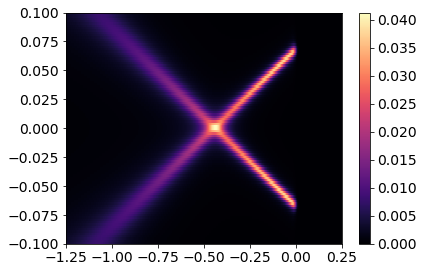

In [16]:
experiment_fullbasis = arpes_lib.experiment(TB,arpes_args)
experiment_fullbasis.datacube()
Imap,Imap_resolution,axes = experiment_fullbasis.spectral(slice_select=('x',Kpt[0]))

Perhaps unsurprisingly, the result is the same, as symmetries of the 2D lattice preclude hybridization of the Carbon 2p$_z$ orbitals with any of the other 2sp states.

# Manipulating the Hamiltonian


We can go beyond here and now start playing with our Hamiltonian. One possibility is to consider the effect of breaking inversion symmetry by imposing an onsite energy difference between the two Carbon sites. This is the familiar Semenoff mass proposed by UBC's Gordon Semenoff, as it modifies the massless Dirac dispersion near the K-point to become massive. I will define a simple helper function for this task: 

In [17]:
def semenoff_mass(TB,mass):
    
    Hnew = [[0,0,0,0,0,mass/2],
            [1,1,0,0,0,-mass/2]]
    
    TB.append_H(Hnew)

I can then call this function, acting on the pz-only model:

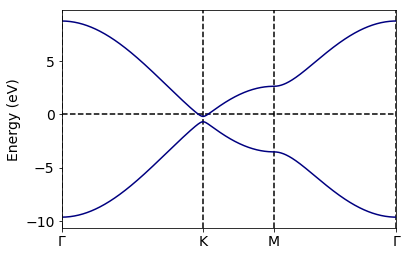

In [18]:
TB_semenoff = build_lib.gen_TB(basis,hamiltonian_args,kpath)
semenoff_mass(TB_semenoff,0.5)

TB_semenoff.Kobj = kpath
TB_semenoff.solve_H()
TB_semenoff.plotting()


By breaking inversion symmetry in the crystal, I have opened a gap at the K-point. The Dirac point need only be degenerate if both inversion and time reversal symmetries are preserved. Note that I have redefined my kpath to follow the same points as before, as the ARPES calculations impose the mesh of k-points used. Near the k-point, rather than have 'bonding' and 'anti-bonding' character, the Semenoff mass localizes the the wavefunction on one or the other sites. Printing the orbital wavefunction near K for the lower and upper states:

/Users/ryanday/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


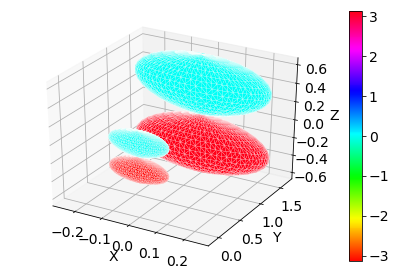

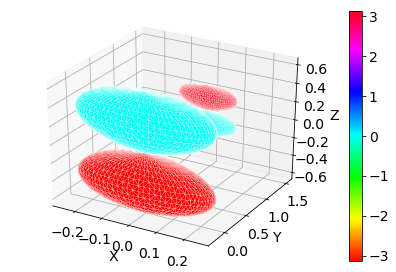

In [19]:
eigenvector1 = TB_semenoff.Evec[190,:,0]
eigenvector2 = TB_semenoff.Evec[190,:,1]

wfunction1 = oplot.wavefunction(basis=TB_semenoff.basis,vector=eigenvector1)
wfunction2 = oplot.wavefunction(basis=TB_semenoff.basis,vector=eigenvector2)

wplot1 = wfunction1.triangulate_wavefunction(20)
wplot2 = wfunction2.triangulate_wavefunction(20)

We see nicely that the eigenvector has been changed from before--while still resembling the symmetric and antisymmetric combinations we had above, now the charge distribution lies predominantly on one or the other site. Try changing the momentum point where you evaluate this, or increasing/decreasing the size of the mass term to observe its effect. I can compute the photoemission again, resulting in a gapped spectrum

Initiate diagonalization: 
Diagonalization Complete.
Begin computing matrix elements: 
||||||||||||||||||||||||||||||100%
Done matrix elements


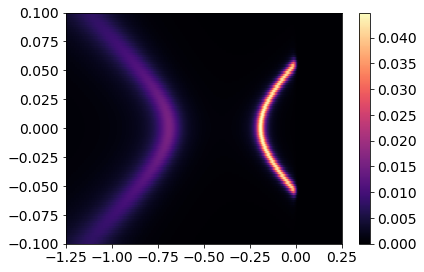

In [20]:
experiment_semenoff = arpes_lib.experiment(TB_semenoff,arpes_args)
experiment_semenoff.datacube()
_ = experiment_semenoff.spectral(slice_select=('x',Kpt[0]))

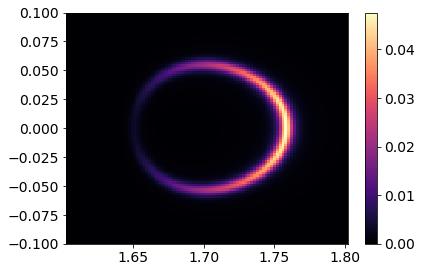

In [21]:
_ = experiment_semenoff.spectral(slice_select=('w',-0.0))

In addition to the gap, we also see the modification of the eigenstate manifest in the redistribution of spectral weight on the Fermi surface, which no longer features the complete extinction of intensity on the inside the cone.

While the Semenoff mass does not break time-reversal symmetry, Duncan Haldane proposed a different form of perturbation which would have this effect. The Haldane model introduces a complex second-nearest neighbour hopping which has opposite sign on the two sublattice sites. I'll define again a function to introduce this perturbation:

In [22]:
def haldane_mass(TB,mass):

    Hnew = []
    vectors = [TB.avec[0],TB.avec[1],TB.avec[1]-TB.avec[0]]
    for ii in range(2):
        for jj in range(3):
            Hnew.append([ii,ii,*vectors[jj],-(2*ii-1)*0.5j*mass])
            Hnew.append([ii,ii,*(-vectors[jj]),(2*ii-1)*0.5j*mass])

    TB.append_H(Hnew)

This function generates the simplest form of Haldane mass, with fixed phase. You can try modifying the above function to allow for arbitrary phase. 

I'm going to define a separate tight-binding model for this perturbation, identical to the unperturbed p$_z$-only basis I used above. I'll then add a Haldane mass term which will result in roughly the same energy splitting as for the Semenoff mass.

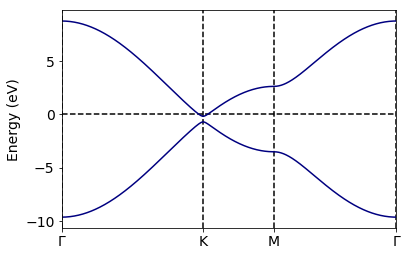

In [23]:
TB_haldane = build_lib.gen_TB(basis,hamiltonian_args,kpath)
haldane_mass(TB_haldane,0.3)
TB_haldane.solve_H()
TB_haldane.plotting()

Evidently, we have effectively the same dispersion as before--breaking time-reversal symmetry now has the effect of gapping out the Dirac cone just as inversion symmetry breaking did.

Finally, I can of course also choose to add both a Haldane and a Semenoff mass. For a critically large Haldane mass, I enter a topologically non-trivial phase. In this case, it is useful to consider both inequivalent Dirac points in the unit cell. So I use a modified k-path here:

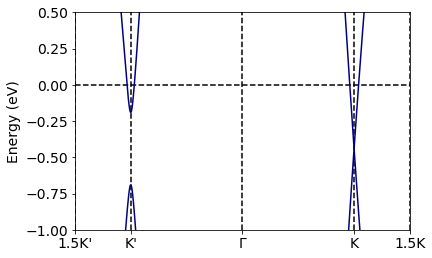

In [24]:
momentum_args= {'type':'F',
                'avec':avec,
                'grain':500,
                'pts':[-1.5*K,-K,G,K,1.5*K],
                'labels':["1.5K'","K'",'$\\Gamma$','K','1.5K']}

kpath_halsem = build_lib.gen_K(momentum_args)
TB_halsem = build_lib.gen_TB(basis,hamiltonian_args,kpath_halsem)
haldane_mass(TB_halsem,0.25/np.sqrt(3))
semenoff_mass(TB_halsem,0.25)
TB_halsem.solve_H()
TB_halsem.plotting(-1,0.5)

There we go, I've now broken both time-reversal and inversion symmetry, modifying the dispersion in a non-trivial way. While the $K$ and $K'$ points will be energetically inequivalent for arbitrary choices of $m_S$ and $m_H$, at $m_H$=$m_S/\sqrt{3}$ (as written in our formalism), the gap at $K$ closes. This can be contrast with the choice of Semenoff, and Haldane only, along this same path through both inequivalent k-points of the Brillouin zone.

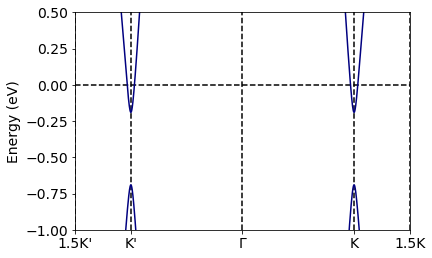

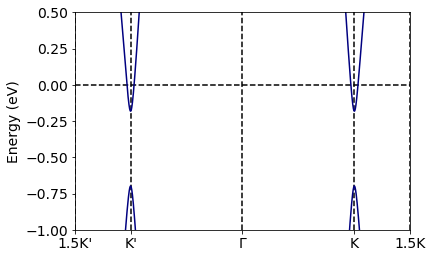

In [25]:
TB_semenoff.Kobj = kpath_halsem
TB_haldane.Kobj = kpath_halsem

TB_semenoff.solve_H()
TB_haldane.solve_H()

TB_semenoff.plotting(-1,0.5)
TB_haldane.plotting(-1,0.5)

It is clear from this that the presence of either time-reversal or inversion symmetry preserve the energy-equivalence of the dispersion at $K$ and $K'$, and only by breaking both symmetries can we change this. Finally, we can compute the ARPES intensity for the system with critical Haldane and Semenoff masses at the $K$ and $K'$ points.

Initiate diagonalization: 
Diagonalization Complete.
Begin computing matrix elements: 
||||||||||||||||||||||||||||||100%
Done matrix elements


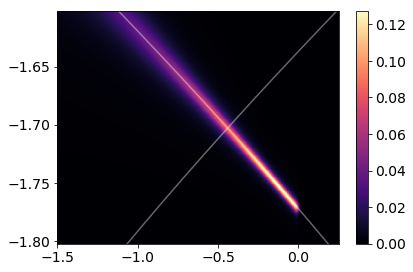

In [26]:
arpes_args['cube']['X'] =[-Kpt[0]-klimits,-Kpt[0]+klimits,500]
arpes_args['cube']['Y'] =[0,0,1]
arpes_args['cube']['E'] = [-1.5,0.25,1000]

experiment_halsem = arpes_lib.experiment(TB_halsem,arpes_args)
experiment_halsem.datacube()
_ = experiment_halsem.spectral(slice_select=('y',0),plot_bands=True)




Initiate diagonalization: 
Diagonalization Complete.
Begin computing matrix elements: 
||||||||||||||||||||||||||||||100%
Done matrix elements


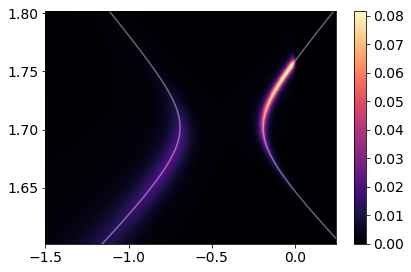

In [27]:
arpes_args['cube']['X'] =[Kpt[0]-klimits,Kpt[0]+klimits,500]
experiment_halsem = arpes_lib.experiment(TB_halsem,arpes_args)
experiment_halsem.datacube()
_ = experiment_halsem.spectral(slice_select=('y',0),plot_bands=True)